# Градиентный бустинг
## 1. Сравнение градиентного бустинга и решающего леса.

Сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

- сгенерируем точки, разбитые на две группы: внутри каждой группы точки лежат в окрестности некоторой прямой
- наша цель: понять, смогут ли бэггинг и градиентный бустинг понять эту зависимость (т.е. понять, что точки внутри каждйо группы лежат в окрестности некоторой прямой)

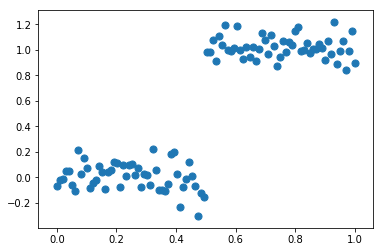

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.scatter(X_train, Y_train, s=50)

Начнём с бэггинга, а именно, с решающего леса.

8it [00:01,  2.64it/s]


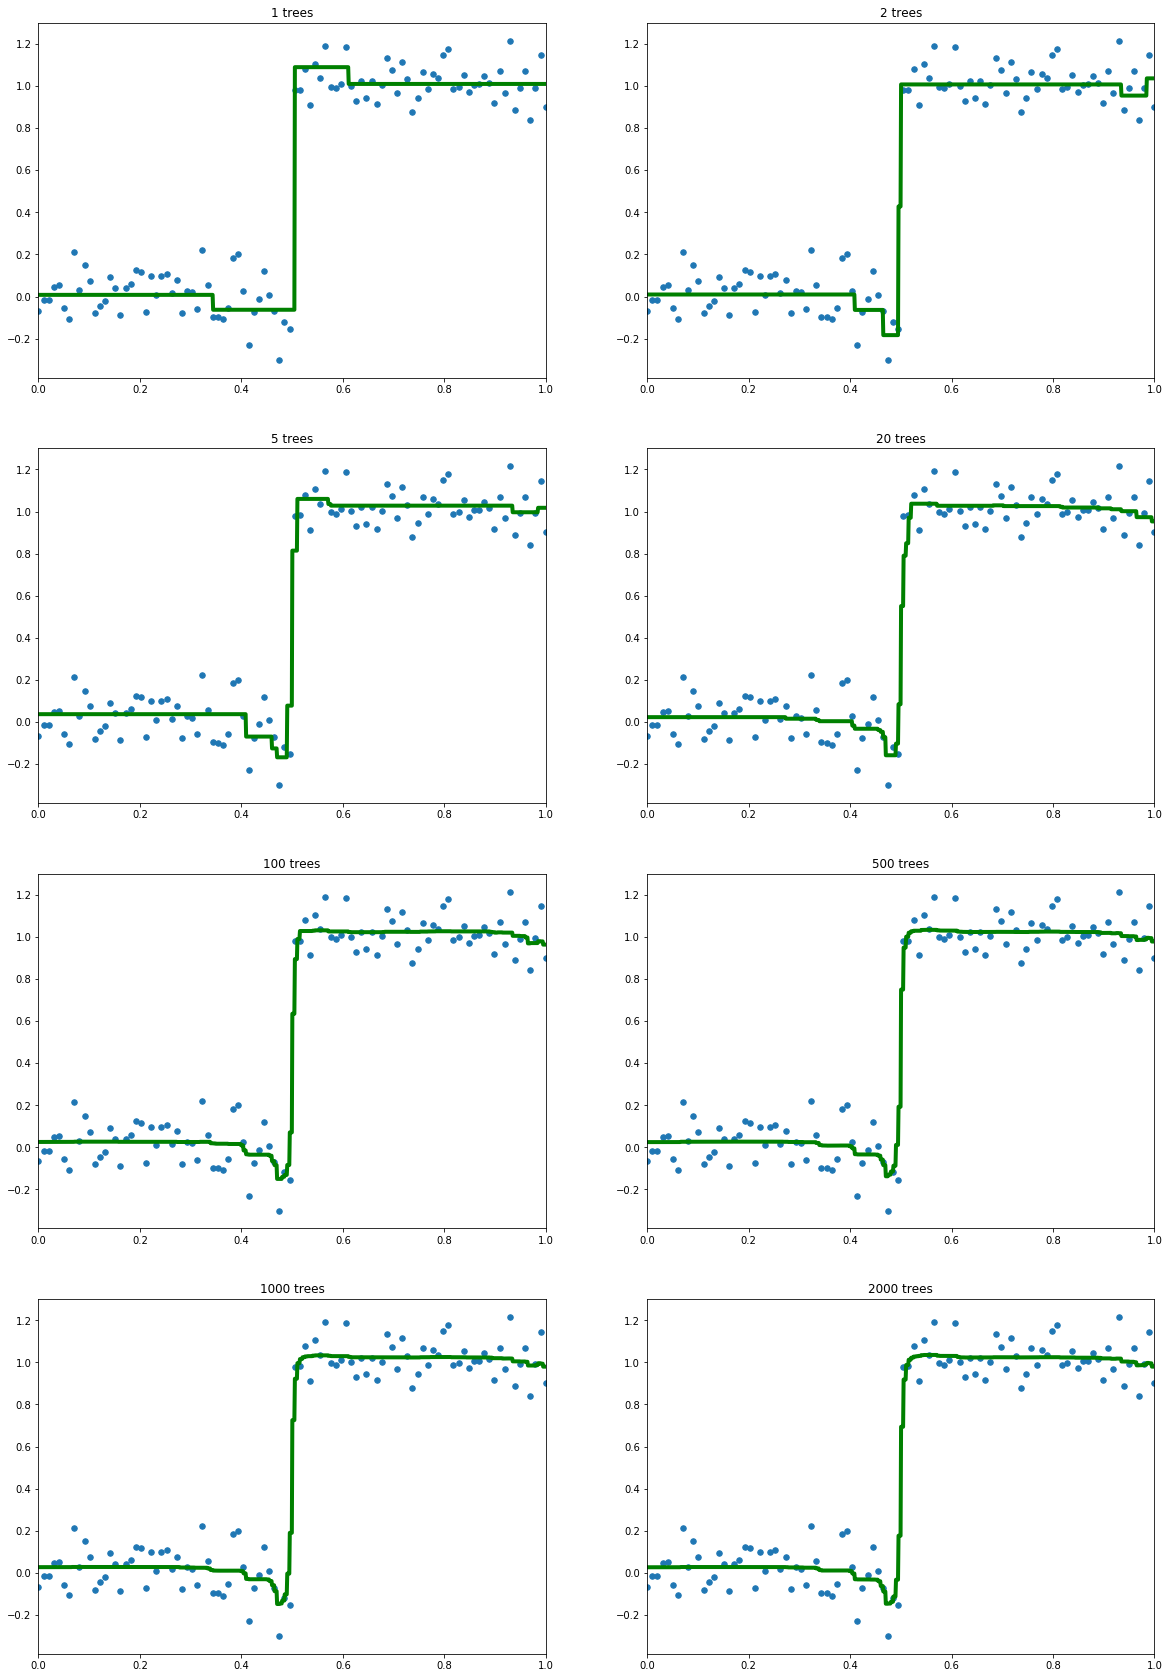

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tqdm import tqdm

reg = RandomForestRegressor(max_depth=2)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in tqdm(enumerate(sizes)):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

8it [00:00, 12.76it/s]


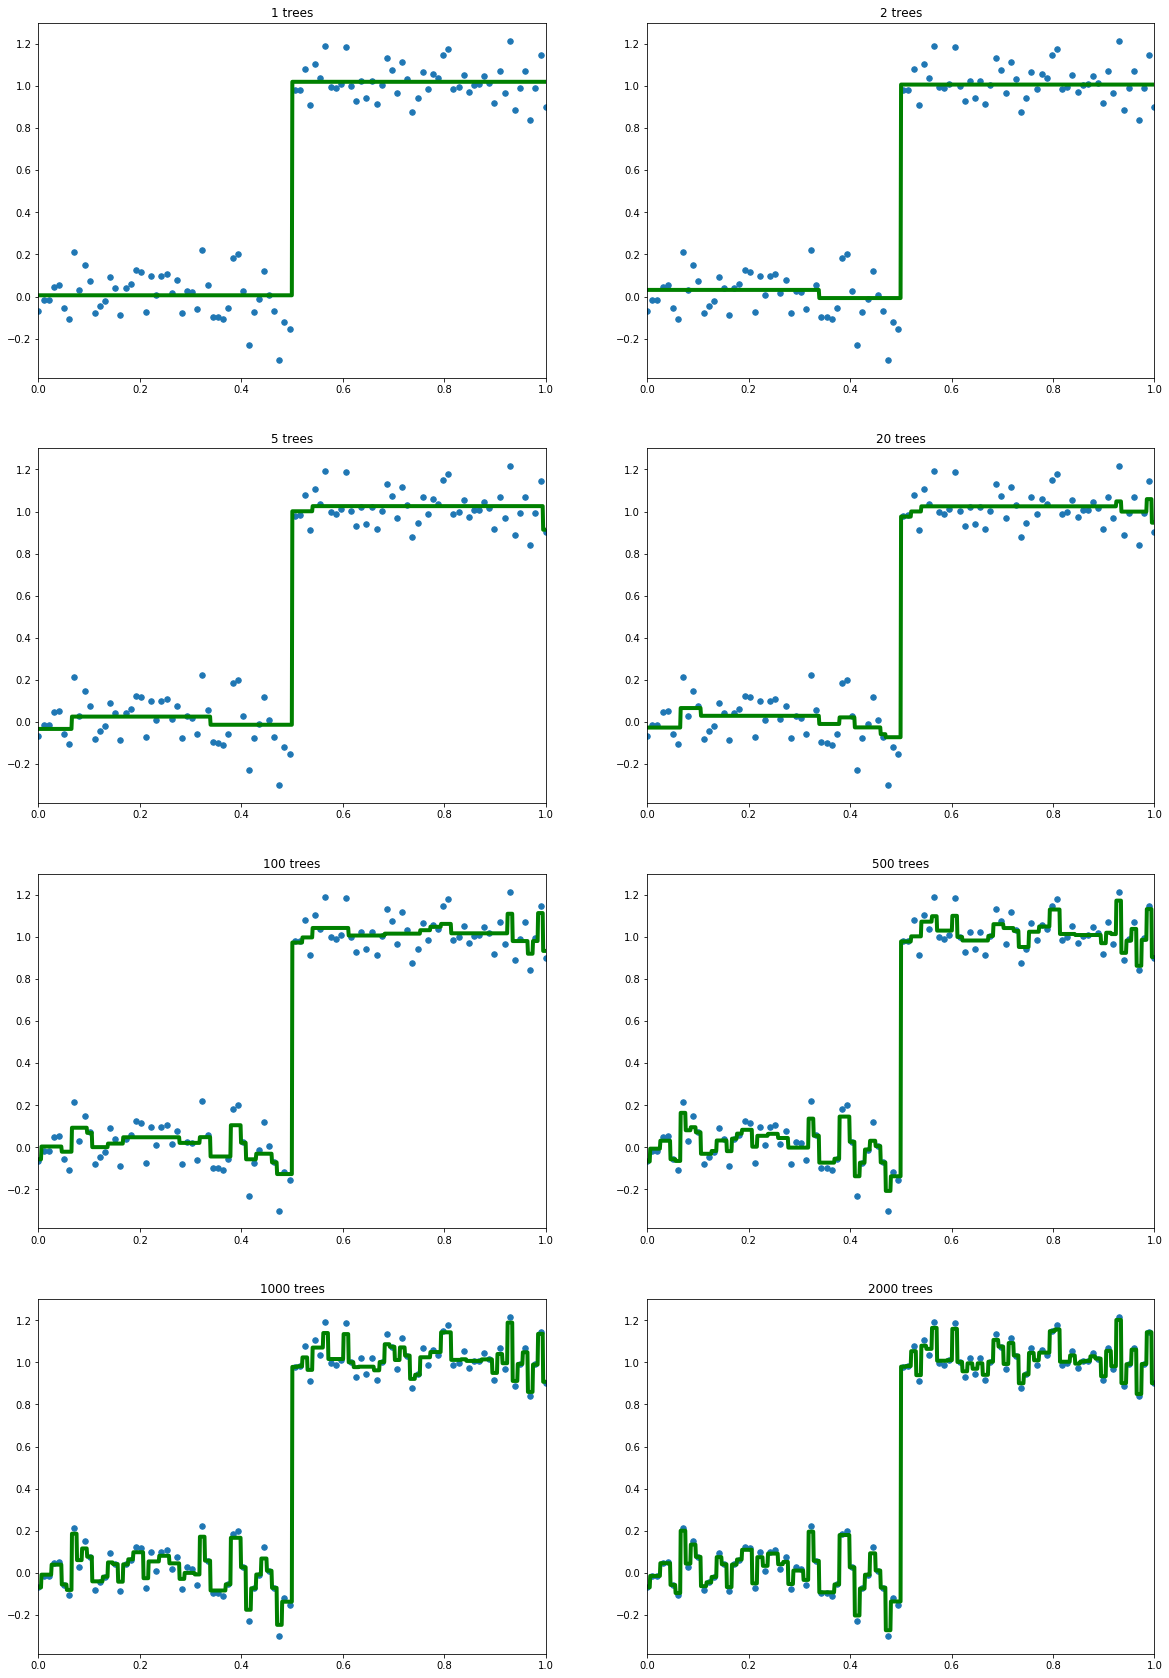

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in tqdm(enumerate(sizes)):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи ***шага $\eta$***:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

***Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм***. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

8it [00:00, 21.91it/s]


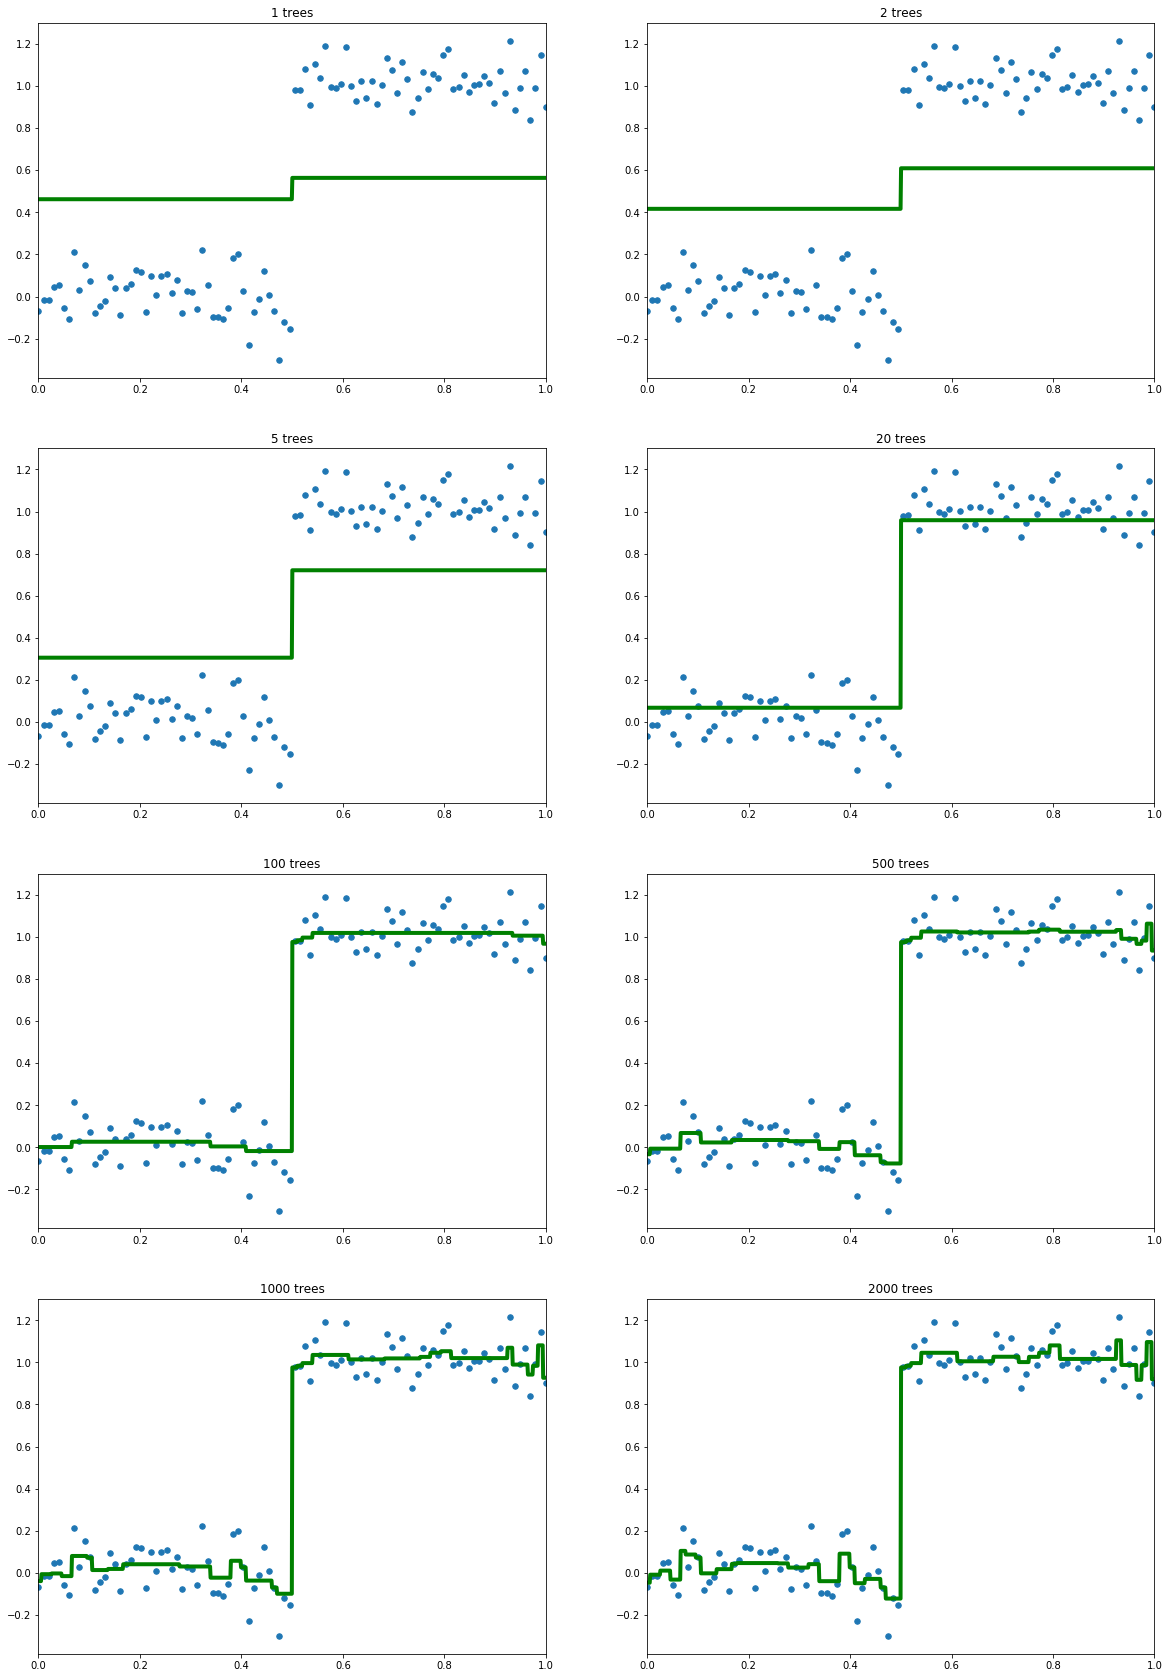

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in tqdm(enumerate(sizes)):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

## 2. Решение задачи регрессии с помощью градиентного бустинга и решающего леса.

Будем решать задачу регрессии на примере датасета **Diabetes**.
По различным факторам будем предсказывать количественный эффект от лечения диабетиков спустя год.

In [24]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
print(ds.DESCR)
X = ds.data
Y = ds.target

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

* Разобъем данные на train и test. 
* Объявим модель бустинга и создадим списки, в которые будем записывать ошибку на train и test в зависимости от количества деревьев в композиции.

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5)

MAX_ESTIMATORS = 250

model = GradientBoostingRegressor(random_state=111)
err_train_gb = []
err_test_gb = []

C:\Users\elena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Для каждого числа деревьев в промежутке (1, MAX_ESTIMATORS+1) обучим на train градиентный бустинг и запишем в созданные списки полученную ошибку: 1 - r2.

In [8]:
for i in range(1, MAX_ESTIMATORS+1):
    model.n_estimators = i
    model.fit(X_train, Y_train)
    err_train_gb.append(1 - model.score(X_train, Y_train))
    err_test_gb.append(1 - model.score(X_test, Y_test))

Повторим все проделанные шаги для решающего леса.

In [9]:
model = RandomForestRegressor(random_state=222)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    model.n_estimators = i
    model.fit(X_train, Y_train)
    err_train_bag.append(1 - model.score(X_train, Y_train))
    err_test_bag.append(1 - model.score(X_test, Y_test))

Text(0.5, 1.0, 'Test')

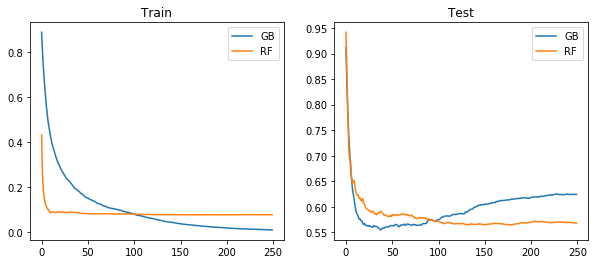

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='RF')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='RF')
plt.legend()
plt.title('Test')

* Мы видим, что случайный лес достигает некоторой минимальной ошибки на обучении и на тесте и дальше не меняет своего качества.

* При этом ошибка градиентного бустинга всё время уменьшается на обучении (стремится к нулю), а на тесте с какого-то момента начинает расти, то есть начинается переобучение.

### Ответим на следующие вопросы:
* ***Как подобрать количество деревьев в RandomForest для достижения наилучшего качества и наименьших временных затрат?***
* ***Как подобрать количество деревьев в GradientBoosting для достижения наилучшего качества и не переобучиться?***

**Ответим на первый вопрос**: как подобрать количество деревьев в RandomForest для достижения наилучшего качества и наименьших временных затрат? 

Text(0.5, 1.0, 'Test')

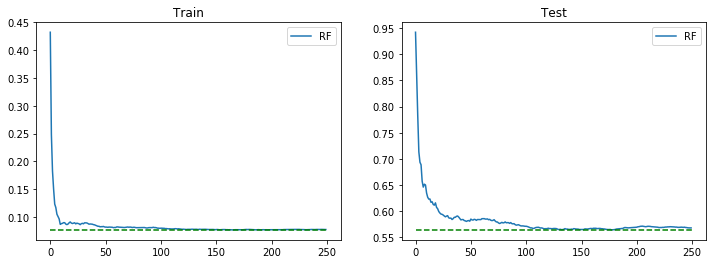

In [11]:
err_train_bag = np.array(err_train_bag)
err_test_bag = np.array(err_test_bag)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_bag, label='RF')
plt.plot([0, err_train_bag.shape[0]], [err_train_bag.min(), err_train_bag.min()], 'g--')

plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_bag, label='RF')
plt.plot([0, err_test_bag.shape[0]], [err_test_bag.min(), err_test_bag.min()], 'g--')
plt.legend()
plt.title('Test')

Мы видим, что начиная примерно с 50-60 деревьев в лесе ошибка на train и на test перестает уменьшаться и колеблется около своего минимума. Поэтому ***для обучения леса в этой задаче достаточно 50-60 деревьев***.

**Ответим на второй вопрос**: как подобрать количество деревьев в GradientBoosting для достижения наилучшего качества и не переобучиться? 

Так как *ошибка на трейне в бустинге всегда уменьшается*, то ***для снижения переобучения найдем количество деревьев, требуемое для достижения минимальной ошибки на тесте***.

Text(0.5, 1.0, 'test error=0.555, best_est=38')

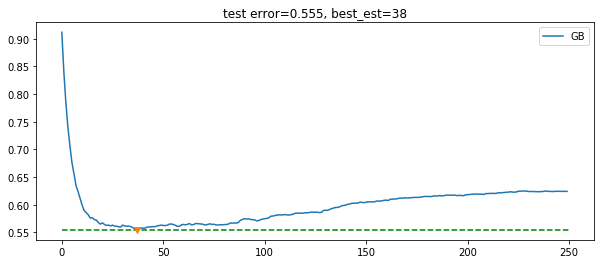

In [12]:
err_train_gb = np.array(err_train_gb)
err_test_gb = np.array(err_test_gb)

plt.figure(figsize=(10, 4))
plt.plot(err_test_gb, label='GB')
plt.legend()
plt.title('Test')

plt.plot([0, err_test_gb.shape[0]], [err_test_gb.min(), err_test_gb.min()], 'g--')
plt.plot([err_test_gb.argmin()], [err_test_gb.min()], 'v')
plt.title('test error=%.3f, best_est=%d' % (err_test_gb.min(), err_test_gb.argmin()+1))

Мы видим, что минимальная ошибка достигается при $n=25$ деревьях.

Сравним ошибку решающего леса и ошибку бустинга на тесте.

In [13]:
print('Random Forest:', err_test_bag.min(), 'n_trees:', err_test_bag.argmin()+1)
print('Gradient Boosting:', err_test_gb.min(), 'n_trees:', err_test_gb.argmin()+1)

Random Forest: 0.5642324668065367 n_trees: 178
Gradient Boosting: 0.5545921511161362 n_trees: 38


#### Выводы:

* Мы видим, что в данной задаче случайный лес дает качество, немного лучшее, чем градиентный бустинг. В других задачах может получиться обратная ситуация.

* Случайный лес не переобучается, поэтому для него не обязательно искать оптимальное количество деревьев (полезно только найти минимальное необходимое число деревьев, чтобы снизить время обучения).

* Для градиентного бустинга ***необходимо*** находить оптимальное количество деревьев, чтобы избежать переобучения.

Посмотрим, можно ли улучшить качество градиентного бустинга за счёт подбора гиперпараметров.

Без подбора параметров с оптимальным числом деревьев градиентный бустинг дает следующее качество:

In [85]:
from sklearn.model_selection import cross_val_score

model = GradientBoostingRegressor(n_estimators=25, random_state=111)

cross_val_score(model, X, Y, cv=3, scoring='r2').mean()

0.42625726022074134

Подберем основные параметры (n_estimators, max_features, max_depth) по сетке. Так как поиск по сетке занимает длительное время, число деревьев будем искать в маленьком диапазоне и с шагом 5.

![Поиск по сетке (GridSearch)](gridsearch.jpg)

In [104]:
from sklearn.model_selection import GridSearchCV

%time
gs = GridSearchCV(GradientBoostingRegressor(random_state=111),
                  param_grid={'n_estimators': range(10,50,5),
                             'max_features': range(1,X.shape[1]+1), 
                             'max_depth': range(2,20)},
                  cv=3,
                  scoring='r2', verbose=1, n_jobs=-1)
gs.fit(X, Y)

Wall time: 0 ns
Fitting 3 folds for each of 3240 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3259 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 5579 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 7179 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 8979 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed:  1.5min finished
C:\Users\elena\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...e=111, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': range(10, 100, 5), 'max_features': range(1, 11), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [106]:
gs.best_score_, gs.best_params_

(0.46540097909184835, {'max_depth': 2, 'max_features': 1, 'n_estimators': 95})

Устроим более полный поиск параметров по сетке: будем также искать learning_rate, min_samples_leaf, min_samples_split, subsample.

In [76]:
%time
gs = GridSearchCV(GradientBoostingRegressor(random_state=111),
                  param_grid={'n_estimators': range(10,500),
                             'max_features': range(1,X.shape[1]+1), 
                             'max_depth': range(2,10),
                             'learning_rate': np.arange(0.1,1.1,0.1),
                             'min_samples_leaf': range(1,10),
                             'min_samples_split': np.arange(0.1,1.1,0.1),
                             'subsample': np.arange(0.1,1.1,0.1)},
                  cv=3,
                  scoring='r2', verbose=1, n_jobs=-1)
gs.fit(X, Y)

Wall time: 0 ns


KeyboardInterrupt: 

Мы видим, что поиск по большому числу параметров занимает очень много времени. Поэтому используем другой вариант подбора параметров, основанный на байесовских методах - **hyperopt**.

Для того, чтобы уменьшить число итераций до нахождения хорошей конфигурации, придуманы адаптивные байесовские методы. Они выбирают следующую точку для проверки, учитывая результаты на уже проверенных точках. Идея состоит в том, чтобы на каждом шаге найти компромисс между (а) исследованием регионов рядом с самыми удачными точками среди найденных и (б) исследованием регионов с большой неопределенностью, где могут находиться еще более удачные точки. Это часто называют дилеммой explore-exploit или «learning vs earning». Таким образом, в ситуациях, когда проверка каждой новой точки стоит дорого (в машинном обучении проверка = обучение + валидация), можно приблизиться к глобальному оптимуму за гораздо меньшее число шагов (подробнее см. https://habr.com/ru/company/dca/blog/272697/).

![Hyperopt](tpesearch.png)

In [117]:
from hpsklearn import HyperoptEstimator, gradient_boosting_regression
from hyperopt import tpe

estim = HyperoptEstimator(regressor=gradient_boosting_regression('reg'),  
                            algo=tpe.suggest, max_evals=100)

estim.fit(X_train, Y_train)

print(estim.score(X_test, Y_test))
print(estim.best_model())

100%|████████████████████████████████████████████████| 68/68 [00:01<00:00,  1.84s/trial, best loss: 0.5665077286216023]


100%|██████████████████████████████████████████████| 100/100 [00:01<00:00,  1.80s/trial, best loss: 0.5665077286216023]
0.4252710990385397
{'learner': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.08393875339397712, loss='lad', max_depth=None,
             max_features=0.2725130577419666, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=41,
             n_iter_no_change=None, presort='auto', random_state=3,
             subsample=0.8238002720680311, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}


In [116]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

model = Pipeline([('Scaler', estim.best_model()['preprocs'][0]),
                 ('RF', estim.best_model()['learner'])])
#model = estim.best_model()['learner']

cross_val_score(model, X, Y, cv=3, scoring='r2').mean()

0.45367811452912643

Используя hyperopt, можно подбирать параметры у любых других моделей.

# Домашнее задание.
Поработайте с датасетом для классификации https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset#

Загрузим все таблички из датасета (QCM.csv) и объединим их в одну таблицу. 

Последние 5 колонок содержат в себе целевую переменную. Создадим одну колонку с целевой переменной y следующим образом: если 1-Octanol = 1, то y = 0, если 1-Propanol = 1, то y=1, если 2-Butanol = 1, то y=2 и т.д.

Создадим матрицу объект-признак X, содержащую все признаки (кроме последних 5 целевых колонок). 

1) Посчитайте качество DecisionTreeClassifier, RandomForestClassifier и GradientBoostingClassifier на кросс-валидации.

2*) Попробуйте уменьшить число признаков с помощью какого-либо метода отбора признаков (http://scikit-learn.org/stable/modules/feature_selection.html). Добейтесь увеличения на кросс-валидации.

3) Используйте gridsearch или hyperopt для подбора оптимальных параметров у леса и у бустинга. Какого наилучшего качества на кросс-валидации удалось достичь?  

In [ ]:
import pandas as pd

data1 = pd.read_csv("QCM3.csv",delimiter=';')
data2 = pd.read_csv("QCM6.csv",delimiter=';')
data3 = pd.read_csv("QCM7.csv",delimiter=';')
data4 = pd.read_csv("QCM10.csv",delimiter=';')
data5 = pd.read_csv("QCM12.csv",delimiter=';')

#your code here
df = pd.concat([data1, data2, data3, data4, data5])
df.tail()

In [ ]:
def get_target(x):
    if x['1-Octanol'] == 1:
        return 0
    if x['1-Propanol'] == 1:
        return 1
    if x['2-Butanol'] == 1:
        return 2
    if x['2-propanol'] == 1:
        return 3
    if x['1-isobutanol'] == 1:
        return 4
    return -1
    
df['Target'] = df.apply(get_target, axis=1)

df.drop(['1-Octanol','1-Propanol','2-Butanol','2-propanol','1-isobutanol'],\
        axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
X = df.drop('Target',axis=1)
y = df['Target']

In [ ]:
#your code here

dt = DecisionTreeClassifier()

print(cross_val_score(dt, X, y, cv=5, scoring='accuracy').mean())

from sklearn.ensemble import RandomForestClassifier

for n in range(11, 21):
    rf = RandomForestClassifier(n_estimators = n, max_depth=4)
    
    print('n = ',n)
    print(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())